In [1]:
import os
import sys
import babeltrace
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from IPython.display import display, clear_output

sys.path.append("/home/adlink/ros2-workspace/install/tracetools_read/lib/python3.8/site-packages/")
sys.path.append("/home/adlink/ros2-workspace/src/tracetools_analysis/tracetools_analysis/")
from tracetools_read.trace import *
from tracetools_analysis.loading import load_file
from tracetools_analysis.processor.ros2 import Ros2Handler
from tracetools_analysis.utils.ros2 import Ros2DataModelUtil

In [2]:
path = os.path.expanduser("~/.ros/tracing/autoware-trace/")
file = load_file(path)

found converted file: /home/adlink/.ros/tracing/autoware-trace/converted


In [3]:
handler = Ros2Handler.process(file)
util = Ros2DataModelUtil(handler)


 [100%] [Ros2Handler]


In [10]:
n=1
self = handler.data
print('====================ROS 2 DATA MODEL===================')
print('██ Contexts: ██')
print(self.contexts[:n].to_string())
print('██ Nodes: ██')
print(self.nodes[:n].to_string())
print('██ Publishers (rmw): ██')
print(self.rmw_publishers[:n].to_string())
print('██ Publishers (rcl): ██')
print(self.rcl_publishers[:n].to_string())
print('██ Subscriptions (rmw): ██')
print(self.rmw_subscriptions[:n].to_string())
print('██ Subscriptions (rcl): ██')
print(self.rcl_subscriptions[:n].to_string())
print('██ Subscription objects: ██')
print(self.subscription_objects[:n].to_string())
print('██ Services: ██')
print(self.services[:n].to_string())
print('██ Clients: ██')
print(self.clients[:n].to_string())
print('██ Timers: ██')
print(self.timers[:n].to_string())
print('██ Timer-node links: ██')
print(self.timer_node_links[:n].to_string())
print('██ Callback objects: ██')
print(self.callback_objects[:n].to_string())
print('██ Callback symbols: ██')
print(self.callback_symbols[:n].to_string())
print('██ Callback instances: ██')
print(self.callback_instances[:n].to_string())
print('██ Publish instances (rclcpp): ██')
print(self.rclcpp_publish_instances[:n].to_string())
print('██ Publish instances (rcl): ██')
print(self.rcl_publish_instances[:n].to_string())
print('██ Publish instances (rmw): ██')
print(self.rmw_publish_instances[:n].to_string())
print('██ Take instances (rmw): ██')
print(self.rmw_take_instances[:n].to_string())
print('██ Take instances (rcl): ██')
print(self.rcl_take_instances[:n].to_string())
print('██ Take instances (rclcpp): ██')
print(self.rclcpp_take_instances[:n].to_string())
print('██ Lifecycle state machines: ██')
print(self.lifecycle_state_machines[:n].to_string())
print('██ Lifecycle transitions: ██')
print(self.lifecycle_transitions[:n].to_string())
print('==================================================')

====================ROS 2 DATA MODEL===================
██ Contexts: ██
                          timestamp   pid version
context_handle                                   
578889920       1652795531158728529  9807   2.3.0
██ Nodes: ██
                       timestamp   tid  rmw_handle             name namespace
node_handle                                                                  
578605264    1652795531205345494  9807   578658512  launch_ros_9807         /
██ Publishers (rmw): ██
Empty DataFrame
Columns: []
Index: []
██ Publishers (rcl): ██
                            timestamp  node_handle  rmw_handle topic_name  depth
publisher_handle                                                                
281474154018016   1652795531205338094    578605264   580193376    /rosout   1000
██ Subscriptions (rmw): ██
Empty DataFrame
Columns: []
Index: []
██ Subscriptions (rcl): ██
                               timestamp      node_handle       rmw_handle         topic_name  depth
subscript

# Data Structures

In [84]:
from dataclasses import dataclass
from typing import List, Dict

def str_to_cls(classname):
    return getattr(sys.modules[__name__], classname)

def row_to_type(row, type, has_idx):
    return type(id=row.name, **row) if has_idx else type(**row)

def df_to_type_list(df, type):
    if isinstance(type, str):
        type = str_to_cls(type)
        
    has_idx = not isinstance(df.index, pd.RangeIndex)
    return [row_to_type(row, type, has_idx) for _, row in df.iterrows()]

def by_index(df, index, type):
    return df_to_type_list(df.loc[index], type)

def by_column(df, column_name, column_val, type):
    return df_to_type_list(df[df[column_name] == column_val], type)

def list_to_dict(ls, key='id'):
    return {getattr(item, key): item for item in ls}

#################################
# Predefined (from ROS2DataModel)
#################################

@dataclass
class Node:
    id: int
    timestamp: int
    tid: int
    rmw_handle: int
    name: str
    namespace: str

    @property
    def path(self) -> str:
        return os.path.join(self.namespace, self.name)

    @property
    def publishers(self) -> List['Publisher']:
        return list(filter(lambda pub: pub.node_handle == self.id, publishers.values()))

    @property
    def subscriptions(self) -> List['Subscription']:
        return list(filter(lambda sub: sub.node_handle == self.id, subscriptions.values()))
    
    @property
    def timers(self) -> List['Timer']:
        links = [link.id for link in timer_node_links.values() if link.node_handle == self.id]
        return list(filter(lambda timer: timer.id in links, timers.values()))

@dataclass
class Publisher:
    id: int
    timestamp: int
    node_handle: int
    rmw_handle: int
    topic_name: str
    depth: int

    @property
    def node(self) -> 'Node':
        return nodes[self.node_handle]

    @property
    def subscriptions(self) -> List['Subscription']:
        return list(filter(lambda sub: sub.topic_name == self.topic_name, subscriptions.values()))

    @property
    def instances(self) -> List['PublishInstance']:
        return list(filter(lambda inst: inst.publisher_handle == self.id, publish_instances))
    
    @property
    def topic(self) -> 'Topic':
        return topics[self.topic_name]


@dataclass
class Subscription:
    id: int
    timestamp: int
    node_handle: int
    rmw_handle: int
    topic_name: str
    depth: int

    @property
    def node(self) -> 'Node':
        return nodes[self.node_handle]

    @property
    def publishers(self) -> List['Publisher']:
        return list(filter(lambda pub: pub.topic_name == self.topic_name, publishers.values()))
    
    @property
    def subscription_object(self) -> 'SubscriptionObject':
        sub_objs = list(filter(lambda sub_obj: sub_obj.subscription_handle == self.id, subscription_objects.values()))
        assert len(sub_objs) <= 1
        return sub_objs[0] if sub_objs else None

    @property
    def topic(self) -> 'Topic':
        return topics[self.topic_name]
    
@dataclass
class Timer:
    id: int
    timestamp: int
    period: int
    tid: int

    @property
    def nodes(self) -> List['Node']:
        links = [link.node_handle for link in timer_node_links.values() if link.id == self.id]
        return list(filter(lambda node: node.id in links, nodes.values()))
    
    @property
    def callback_object(self) -> 'CallbackObject':
        return callback_objects[self.id]
    
    @property
    def info(self):
        return util.get_timer_handle_info(self.id)

@dataclass
class TimerNodeLink:
    id: int
    timestamp: int
    node_handle: int

@dataclass
class SubscriptionObject:
    id: int             # subscription
    timestamp: int
    subscription_handle: int

    @property
    def subscription(self) -> 'Subscription':
        return subscriptions[self.subscription_handle]

    @property
    def callback_object(self) -> 'CallbackObject':
        return callback_objects[self.id]

    @property
    def info(self):
        return util.get_subscription_reference_info(self.id)

@dataclass
class CallbackObject:
    id: int             # (reference) = subscription_object.id | timer.id | ....
    timestamp: int
    callback_object: int

    @property
    def callback_instances(self) -> List['CallbackInstance']:
        return list(filter(lambda inst: inst.callback_object == self.callback_object, callback_instances))

    @property
    def owner(self):
        if self.id in timers:
            return timers[self.id]
        if self.id in publishers:
            return publishers[self.id]
        if self.id in subscription_objects:
            return subscription_objects[self.id]
        if self.id in handler.data.services.index:
            return 'Service'
        if self.id in handler.data.clients.index:
            return 'Client'
        return None

    @property
    def owner_info(self):
        info = util.get_callback_owner_info(self.callback_object)
        if info is None:
            return None, None
        
        type_name, dict_str = info.split(" -- ")
        kv_strs = dict_str.split(", ")
        info_dict = {k: v for k, v in map(lambda kv_str: kv_str.split(": ", maxsplit=1), kv_strs)}
        return type_name, info_dict

@dataclass
class PublishInstance:
    publisher_handle: int
    timestamp: int
    message: int

    @property
    def publisher(self) -> 'Publisher':
        return publishers[self.publisher_handle]

@dataclass
class CallbackInstance:
    callback_object: int
    timestamp: int
    duration: int
    intra_process: bool

    @property
    def callback_obj(self) -> 'CallbackObject':
        return callback_objects[self.callback_object]

@dataclass
class CallbackSymbol:
    id: int  # callback_object
    timestamp: int
    symbol: str

    @property
    def callback_obj(self) -> 'CallbackObject':
        cb_objs = list(filter(lambda cb_obj: cb_obj.callback_object == self.id, callback_objects.values()))
        assert len(cb_objs) <= 1
        return cb_objs[0] if cb_objs else None


#######################################
# Self-defined (not from ROS2DataModel)
#######################################

@dataclass
class Topic:
    name: str

    @property
    def publishers(self) -> List['Publisher']:
        return list(filter(lambda pub: pub.topic_name == self.name, publishers.values()))
    
    @property
    def subscriptions(self) -> List['Subscription']:
        return list(filter(lambda sub: sub.topic_name == self.name, subscriptions.values()))


In [85]:

#######################################
# Instantiate collections
#######################################

nodes:                  Dict[int, 'Node']               = list_to_dict(df_to_type_list(handler.data.nodes,                  'Node'));               print(f"Processed {len(nodes):<8d} nodes")
publishers:             Dict[int, 'Publisher']          = list_to_dict(df_to_type_list(handler.data.rcl_publishers,         'Publisher'));          print(f"Processed {len(publishers):<8d} publishers")
subscriptions:          Dict[int, 'Subscription']       = list_to_dict(df_to_type_list(handler.data.rcl_subscriptions,      'Subscription'));       print(f"Processed {len(subscriptions):<8d} subscriptions")
timers:                 Dict[int, 'Timer']              = list_to_dict(df_to_type_list(handler.data.timers,                 'Timer'));              print(f"Processed {len(timers):<8d} timers")
timer_node_links:       Dict[int, 'TimerNodeLink']      = list_to_dict(df_to_type_list(handler.data.timer_node_links,       'TimerNodeLink'));      print(f"Processed {len(timer_node_links):<8d} timer-node links")
subscription_objects:   Dict[int, 'SubscriptionObject'] = list_to_dict(df_to_type_list(handler.data.subscription_objects,   'SubscriptionObject')); print(f"Processed {len(subscription_objects):<8d} subscription objects")
callback_objects:       Dict[int, 'CallbackObject']     = list_to_dict(df_to_type_list(handler.data.callback_objects,       'CallbackObject'));     print(f"Processed {len(callback_objects):<8d} callback objects")
callback_symbols:       Dict[int, 'CallbackSymbol']     = list_to_dict(df_to_type_list(handler.data.callback_symbols,       'CallbackSymbol'));     print(f"Processed {len(callback_symbols):<8d} callback symbols")
publish_instances:      List['PublishInstance']         =              df_to_type_list(handler.data.rcl_publish_instances,  'PublishInstance');     print(f"Processed {len(publish_instances):<8d} publish instances")
callback_instances:     List['CallbackInstance']        =              df_to_type_list(handler.data.callback_instances,     'CallbackInstance');    print(f"Processed {len(callback_instances):<8d} callback instances")

_unique_topic_names = {*(pub.topic_name for pub in publishers.values()), *(sub.topic_name for sub in subscriptions.values())}
topics: Dict[str, 'Topic'] = list_to_dict(map(Topic, _unique_topic_names), key="name"); print(f"Processed {len(topics):<8d} topics")

Processed 61       nodes
Processed 264      publishers
Processed 212      subscriptions
Processed 67       timers
Processed 31       timer-node links
Processed 201      subscription objects
Processed 483      callback objects
Processed 483      callback symbols
Processed 183512   publish instances
Processed 390810   callback instances
Processed 161      topics


# Callback-Sub & Callback-Timer Links

In [83]:
import re

sym_table = []

for sym in callback_symbols.values():
    try:
        cbo = list(filter(lambda val: val.callback_object==sym.id, callback_objects.values()))
        assert len(cbo) == 1
        cbo = cbo[0]
    except:
        print(len(cbo))
        continue
    owner_info = cbo.owner_info

    if None in owner_info: continue
    type, info = owner_info
    sym_table.append((sym, type, info))

sym_table.sort(key=lambda tup: tup[1])

def trim(string, length):
    if len(string) > length:
        return f"{string[:length-3]}..."
    return string

for sym, type, info in sym_table:
    sym: CallbackSymbol
    pretty_sym = util._prettify(sym.symbol)
    pretty_sym = re.sub(r"std::shared_ptr<(.*?)>", r"\1*", pretty_sym)
    try:
        i = len(sym.callback_obj.callback_instances)
    except KeyError:
        i = -1
    print(f"{trim(pretty_sym, 100):100s}: i={i:>4d} {type:12s} n={info['node']:40s}", end=' ') 
    if type == 'Timer':
        print(f"p={info['period']:7s}")
    elif type == 'Subscription':
        print(f"t={info['topic']:30s}")
    else:
        print()

void (rclcpp::TimeSource::?)(rcl_interfaces::msg::ParameterEventconst*)                             : i=1026 Subscription n=system_monitor_container                 t=/parameter_events             
void (rclcpp::TimeSource::?)(rcl_interfaces::msg::ParameterEventconst*)                             : i=1042 Subscription n=robot_state_publisher                    t=/parameter_events             
void (rclcpp::TimeSource::?)(rcl_interfaces::msg::ParameterEventconst*)                             : i=1070 Subscription n=system_error_monitor                     t=/parameter_events             
void (AutowareErrorMonitor::?)(diagnostic_msgs::msg::DiagnosticArrayconst*)                         : i=1780 Subscription n=system_error_monitor                     t=/diagnostics_agg              
void (AutowareErrorMonitor::?)(tier4_control_msgs::msg::GateModeconst*)                             : i=1626 Subscription n=system_error_monitor                     t=/control/current_gate_mode    
void (Auto

# Topic-Node Mapping

In [5]:
# Aggregate topics that have the same pubs and subs
topic_cohorts = {}
for topic in topics.values():
    key = (frozenset({*(pub.node_handle for pub in topic.publishers)}), frozenset({*(sub.node_handle for sub in topic.subscriptions)}))
    if key not in topic_cohorts:
        topic_cohorts[key] = []
    topic_cohorts[key].append(topic)

print(f"{len(topics)} topics were aggregated into {len(topic_cohorts)} cohorts")

161 topics were aggregated into 78 cohorts


# Timer-Node Mapping

In [6]:
unknowns = {}

print_node_timer = lambda node_path, period: print(f"{node_path:<90s}: {1/(period*1e-9):8.2f}Hz")

for timer in timers.values():
    timer_nodes = timer.nodes
    if not timer_nodes:
        if timer.period not in unknowns:
            unknowns[timer.period] = 0
        unknowns[timer.period] += 1

    for node in timer_nodes: print_node_timer(node.path, timer.period)
        
for period, count in unknowns.items():
    print_node_timer(f"UNKNOWN (x{count})", period)

n_unknown = sum(unknowns.values())  # Values are counts per period
print(f"Found {len(timers) - n_unknown} timers with a recorded node, {n_unknown} without.")

/system/system_error_monitor                                                              :    10.00Hz
/system/emergency_handler                                                                 :    10.00Hz
/system/ad_service_state_monitor                                                          :     1.00Hz
/planning/scenario_planning/scenario_selector                                             :    10.00Hz
/planning/planning_diagnostics/planning_error_monitor                                     :     1.00Hz
/planning/planning_diagnostics/planning_error_monitor                                     :    10.00Hz
/system/system_monitor/cpu_monitor                                                        :     1.00Hz
/system/system_monitor/hdd_monitor                                                        :     1.00Hz
/control/trajectory_follower/lateral_controller_node_exe                                  :    33.33Hz
/system/system_monitor/hdd_monitor                                       

# Measure Frequency Deviations

In [7]:
# Get Publisher frequencies
df_publications = handler.data.rcl_publish_instances
pub_stats = {}
unknown = 0
for pi in publish_instances:
    try:
        pub = pi.publisher
    except KeyError:
        unknown += 1
        continue
    if pub.id not in pub_stats:
        pub_stats[pub.id] = {'times': []}
    pub_stats[pub.id]['times'].append(pi.timestamp*1e-9) # Nanoseconds to seconds float

print(f"{unknown} unknown publisher handles ({len(pub_stats)} known ones)")

219 unknown publisher handles (176 known ones)


# Plot Frequency Deviations

In [ ]:
fig_dirname = "fig_frequency"
os.makedirs(fig_dirname, exist_ok=True)
for i, (k, v) in enumerate(sorted(pub_stats.items(), key=lambda kv: len(kv[1]['times']), reverse=True)):
    pub_time_diff = np.diff(np.array(v['times']))
    v['period'] = pub_time_diff.mean()
    v['period_std'] = pub_time_diff.std()
    v['frequency'] = 1 / v['period']
    v['frequency_std'] = (1/pub_time_diff).std()

    try:
        publisher = publishers[k]
        publisher_node = publisher.node
        topic_name = publisher.topic_name
        node_path = publisher_node.path
    except Exception:
        topic_name="UNKNOWN"
        node_path="UNKNOWN"
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    ax.hist(1/pub_time_diff)
    ax.set_xlabel("Publication Frequency [Hz]")
    ax.set_ylabel("#Publications")
    ax.set_title(f"{node_path} =({v['frequency']:.2f}Hz)=> {topic_name}")
    plt.savefig(os.path.join(fig_dirname, f"{i:06}{node_path}__{topic_name}".replace('/','-')))


# Data Flow Graph

In [ ]:
node_filters = ["transform_listener_impl", "_monitor"]
topic_filters = ["/rosout", "/parameter_events", "/diagnostics"]

from pyvis.network import Network
net = Network(notebook=True, height='750px', width='100%', bgcolor='#ffffff', font_color='#000000')

net.add_node("INPUT", label="Input", size=100, color="green", physics=False, x=0, y=0)
net.add_node("OUTPUT", label="Output", size=100, color="red", physics=False, x=6000, y=0)


for node in nodes.values():
    if any(f in node.path for f in node_filters): 
        continue
    net.add_node(node.id, label=node.name, title=node.path, size=20, color="#333")

for cohort_key, cohort_topics in topic_cohorts.items():
    cohort_topic_names = [topic.name for topic in cohort_topics if not any(f in topic.name for f in topic_filters)]
    if not cohort_topic_names: 
        continue
    cohort_id="\n".join(cohort_topic_names)
    cohort_weight=len(cohort_topic_names)
    net.add_node(cohort_id, label=" ", title=cohort_id, size=5, color="#333")
    
    pubs = cohort_key[0]
    subs = cohort_key[1]
    n_pubs = len(pubs)
    n_subs = len(subs)
    
    try:
        if not n_pubs:
            net.add_edge("INPUT", cohort_id, arrows="to", color="green", weight=cohort_weight)
        if not n_subs:
            net.add_edge(cohort_id, "OUTPUT", arrows="to", color="red", weight=cohort_weight)

        for pub in pubs:
            net.add_edge(pub, cohort_id, arrows="to", color="green", weight=cohort_weight)
        for sub in subs:
            net.add_edge(cohort_id, sub, arrows="to", color="red", weight=cohort_weight)
    except:
        continue

net.toggle_physics(True)
net.show_buttons()
net.show("graph.html")

# Pub-Use Latencies
Compute for each node and its data dependencies the list of pub-use delays (per-topic-per-node list of pub-use delays)

In [107]:
def filter_none(ls):
    return filter(lambda x: x is not None, ls)

def safe_map(func, ls):
    def safe_func(arg):
        try:
            return func(arg)
        except:
            return None
    
    return map(safe_func, ls)

pub_use_delays = {node.id: {
    'pubs': {}, 
    'invocations': {}, 
    'n_unknown_invocations': 0, 
    'n_pub_timestamps': 0
    } for node in nodes.values()}

for node in nodes.values():
    node_pub_use_dict = pub_use_delays[node.id]
    timestamp_min = np.inf; timestamp_max = 0

    n_pub_timestamps = 0
    for sub in node.subscriptions:
        node_pub_use_dict['pubs'][sub.topic_name] = {}
        for pub in sub.publishers:
            pub_timestamps = [inst.timestamp for inst in pub.instances]

            try:
                pub_t_min = min(pub_timestamps); pub_t_max = max(pub_timestamps)
            except ValueError:
                pub_t_min = np.inf; pub_t_max = 0
            
            if pub_t_min < timestamp_min: timestamp_min = pub_t_min
            if pub_t_max > timestamp_max: timestamp_max = pub_t_max

            node_pub_use_dict['pubs'][sub.topic_name][pub.node.path] = pub_timestamps
            node_pub_use_dict['n_pub_timestamps'] += len(pub_timestamps)

    timer_cb_objs = list(filter_none(safe_map(lambda timer: timer.callback_object, node.timers)))
    subsc_cb_objs = list(filter_none(safe_map(lambda subsc: subsc.subscription_object.callback_object, node.subscriptions)))

    print(f"{node.path:95s} has {len(timer_cb_objs):1d} timer callbacks, {len(subsc_cb_objs):2d} subscription callbacks, {len(node_pub_use_dict['pubs']):2d} subscribed topics.")

    node_invocations = node_pub_use_dict['invocations']

    for cb_obj in timer_cb_objs + subsc_cb_objs:
        cb_invocations = []
        for inst in cb_obj.callback_instances:
            cb_invocations.append((inst.timestamp, inst.duration))

        node_invocations[cb_obj.id] = cb_invocations

/launch_ros_9807                                                                                has 0 timer callbacks,  0 subscription callbacks,  0 subscribed topics.
/system/system_monitor/system_monitor/system_monitor_container                                  has 0 timer callbacks,  1 subscription callbacks,  1 subscribed topics.
/robot_state_publisher                                                                          has 0 timer callbacks,  2 subscription callbacks,  2 subscribed topics.
/system/system_error_monitor                                                                    has 1 timer callbacks,  5 subscription callbacks,  5 subscribed topics.
/aggregator_node                                                                                has 1 timer callbacks,  2 subscription callbacks,  2 subscribed topics.
/system/emergency_handler                                                                       has 1 timer callbacks,  6 subscription callbacks,  5 subscribed 

Ignoring 0 nodes due to filters.
/launch_ros_9807                                                                                has no invocations, skipping.


<ipython-input-117-38f5f659767b>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,5))


/map/map_hash_generator                                                                         has no invocations, skipping.
/_ros2cli_9870                                                                                  has no invocations, skipping.


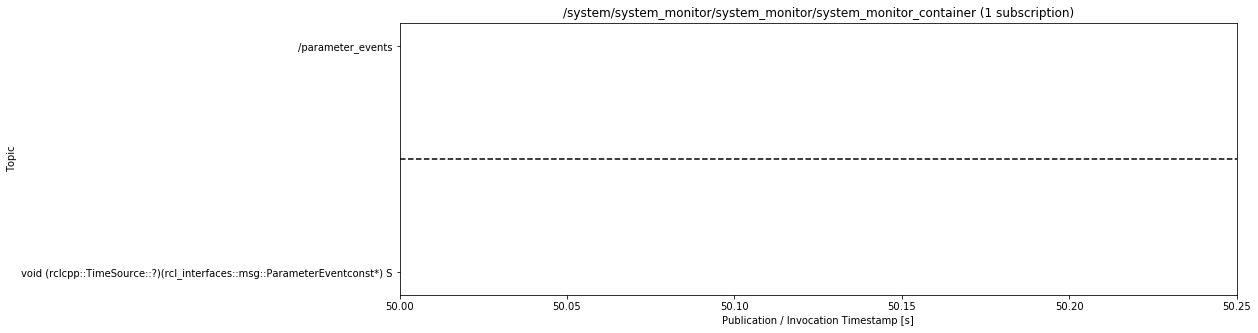

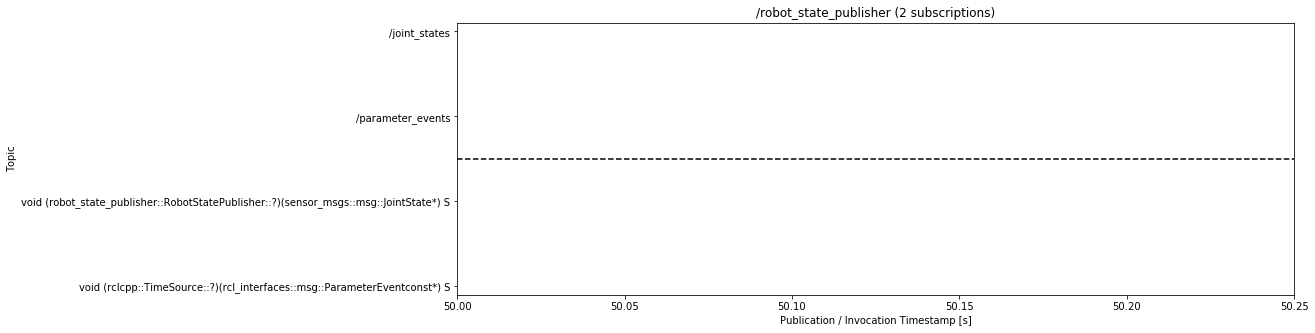

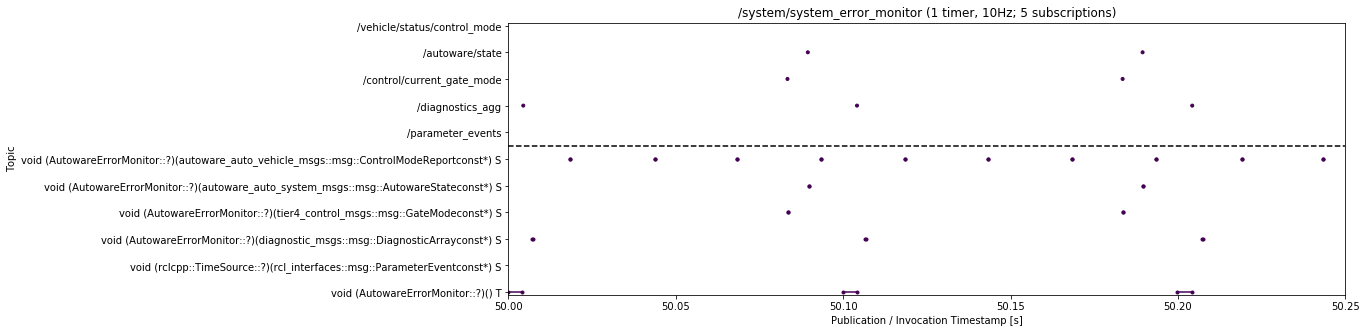

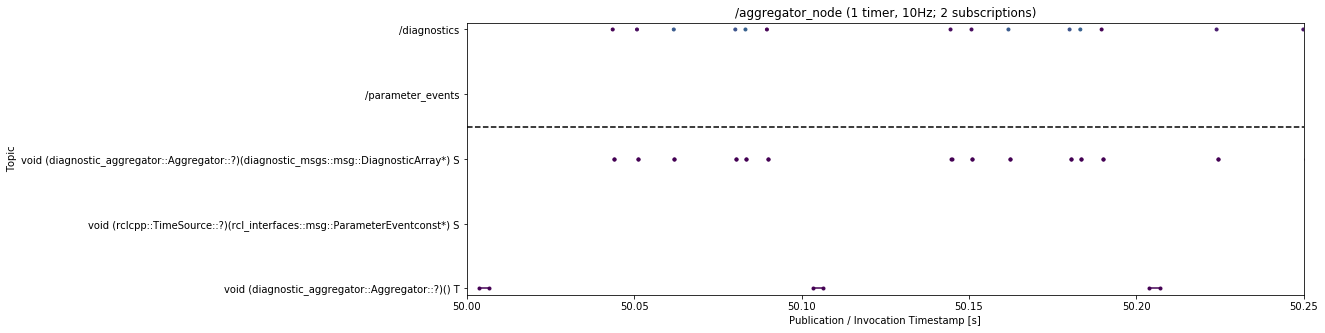

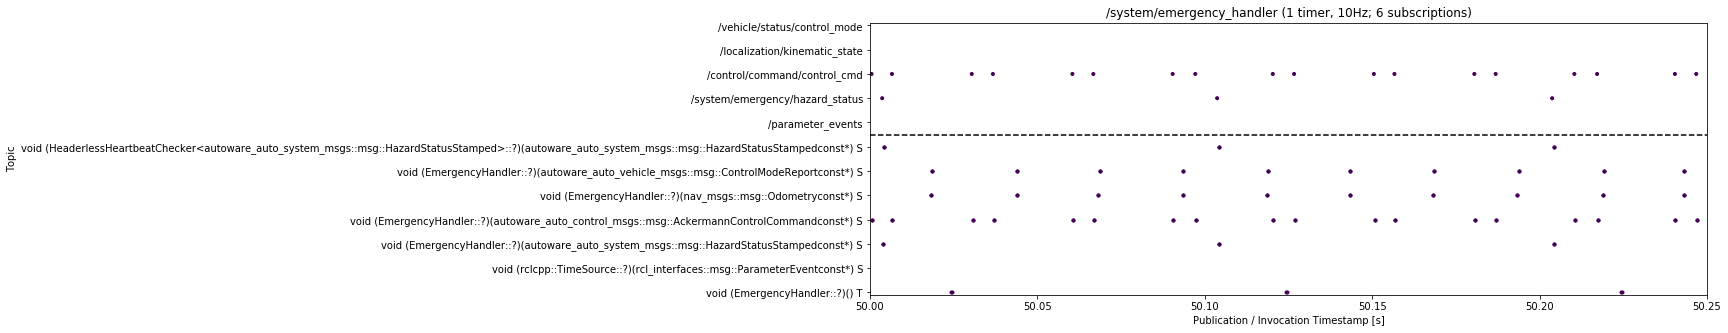

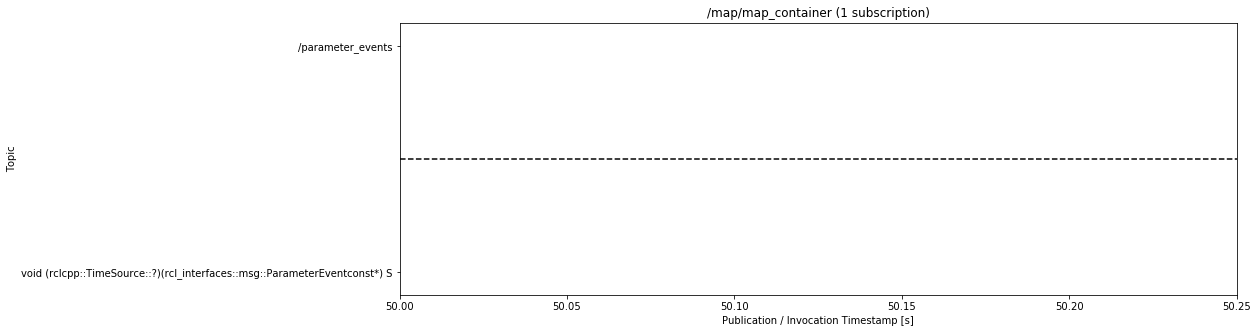

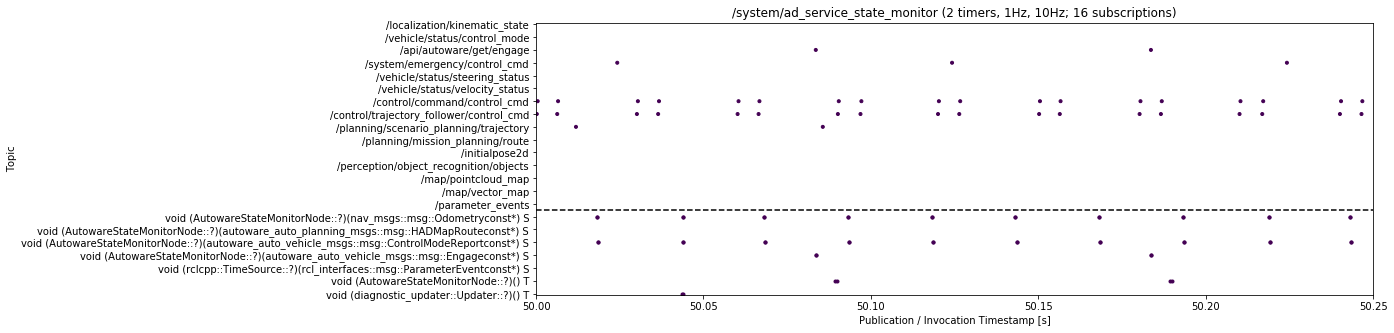

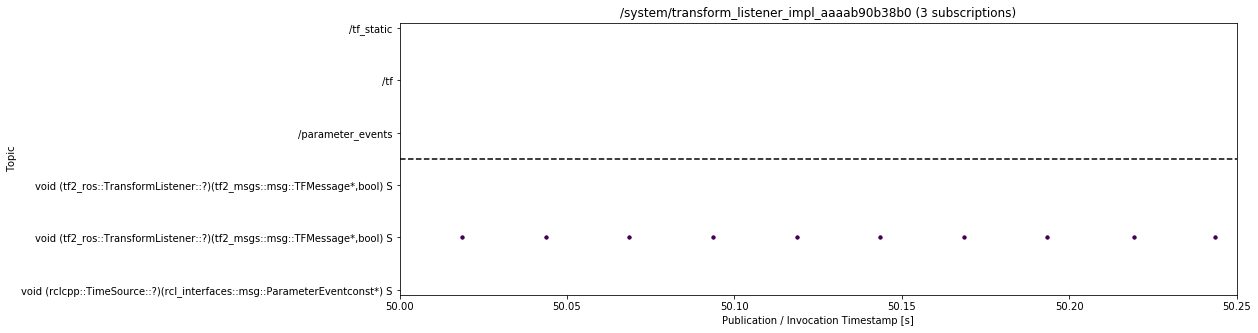

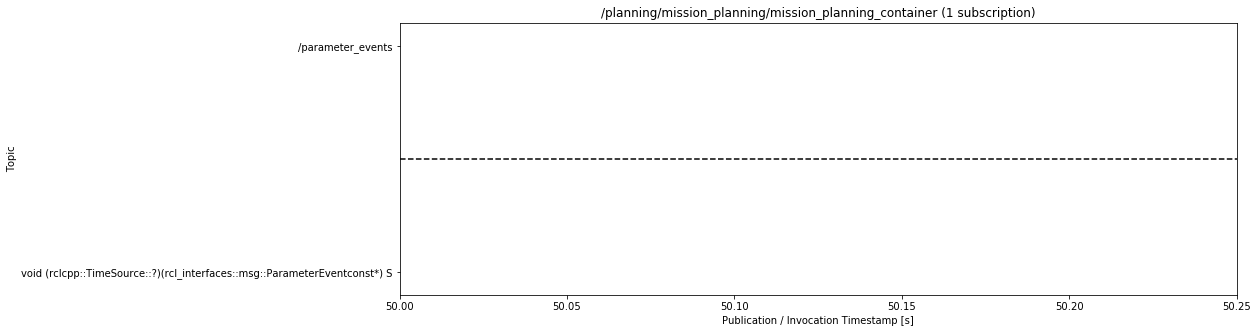

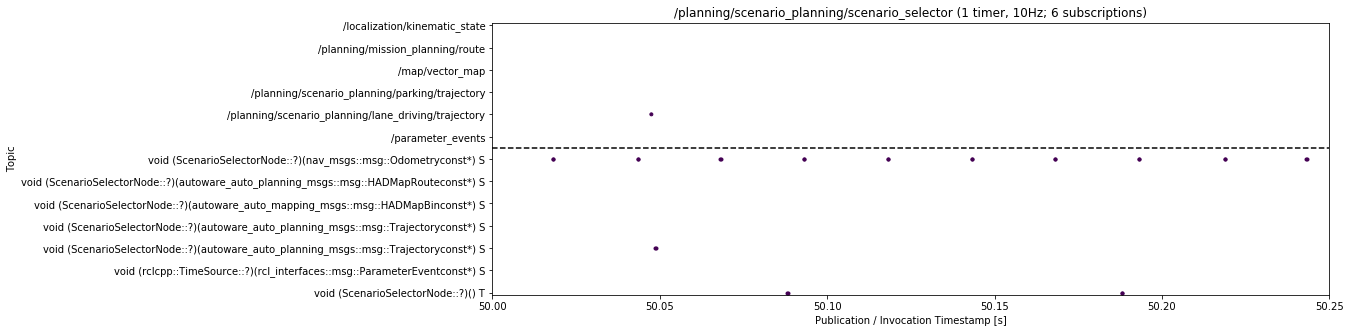

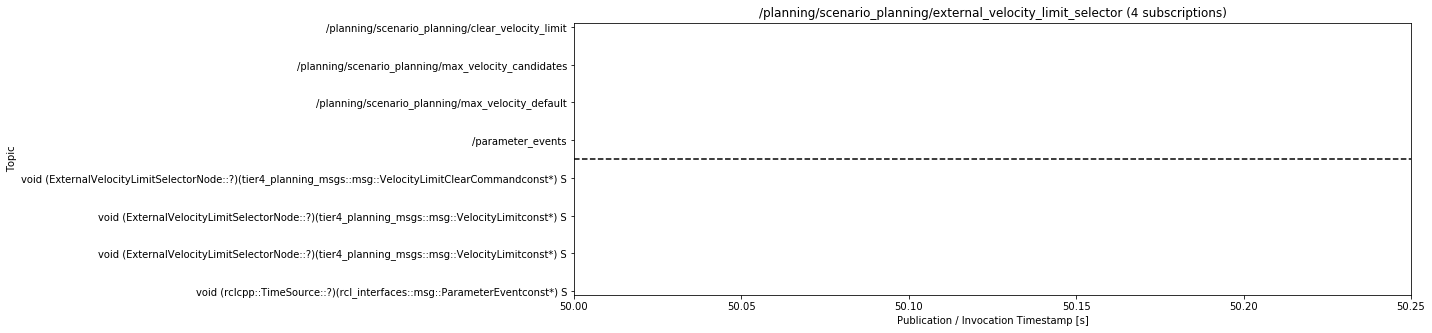

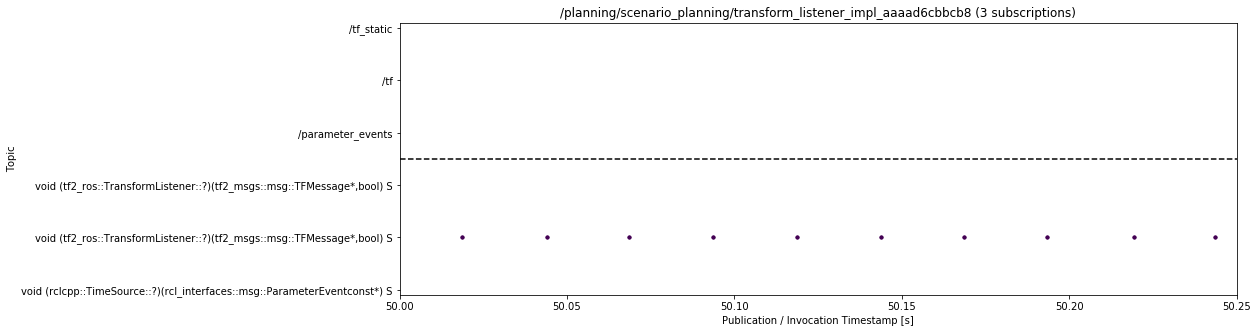

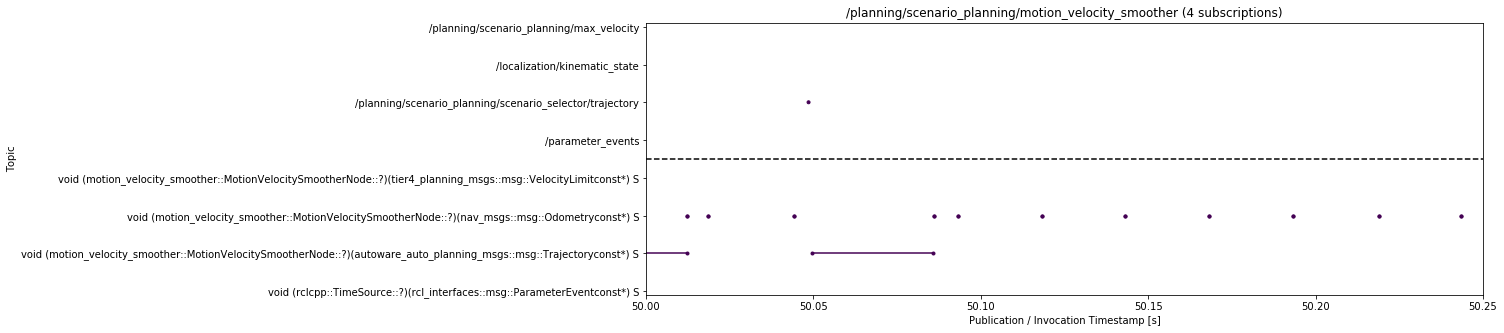

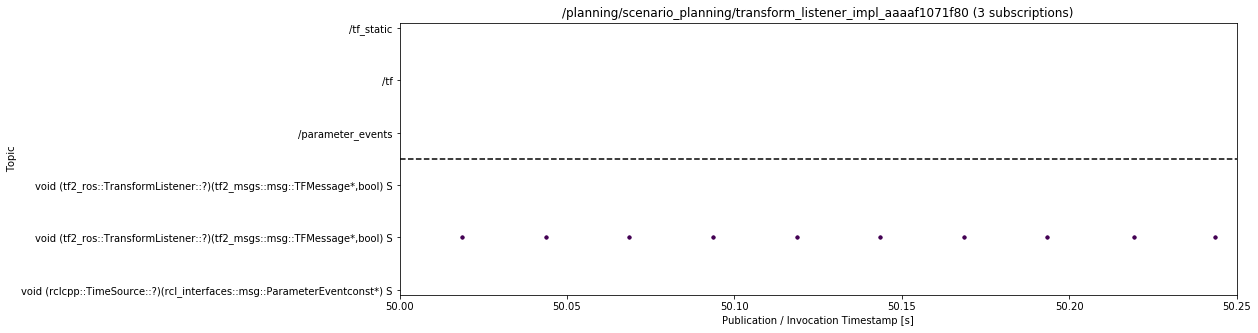

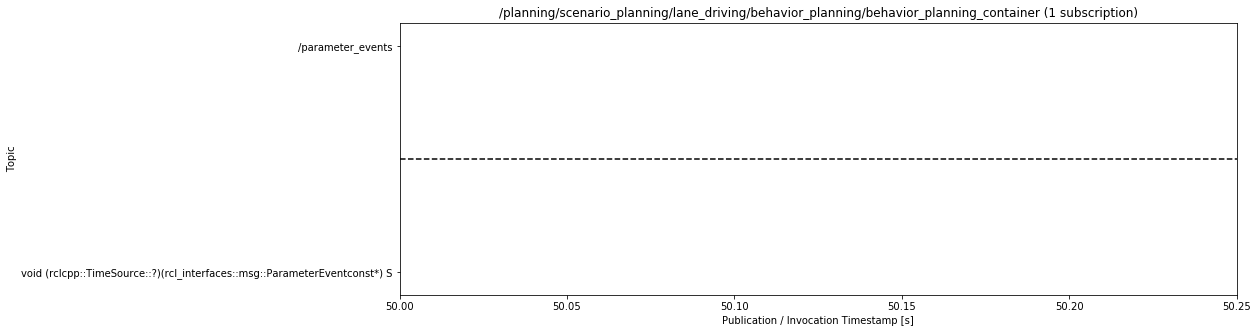

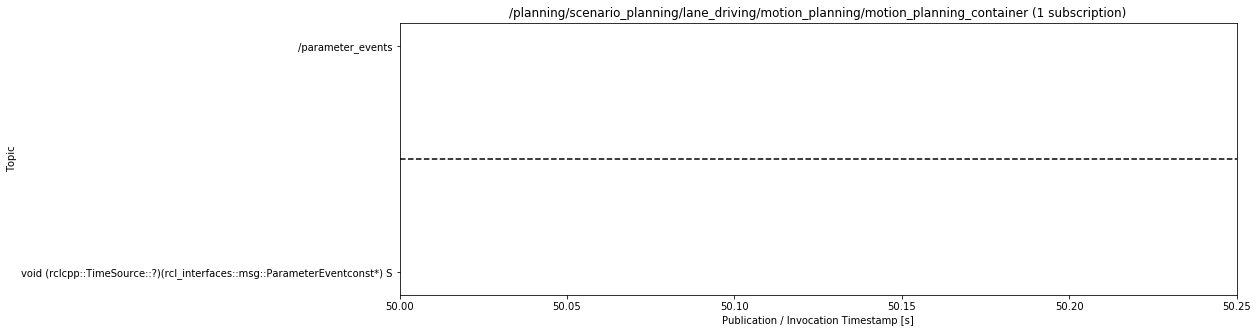

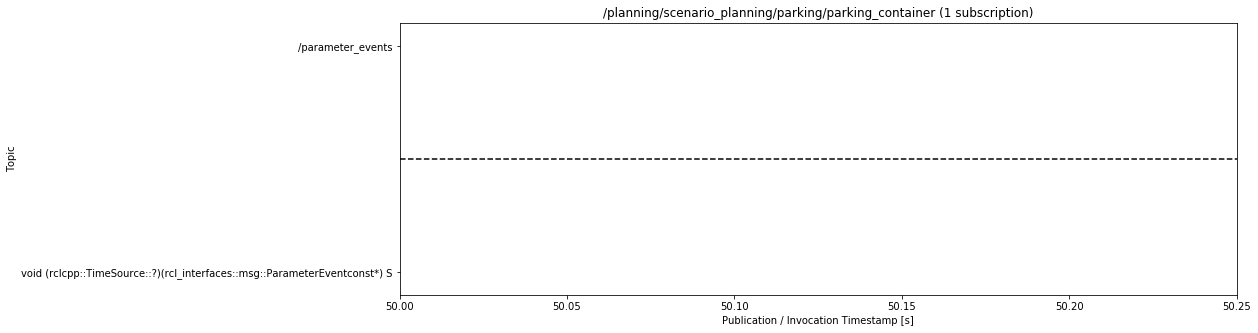

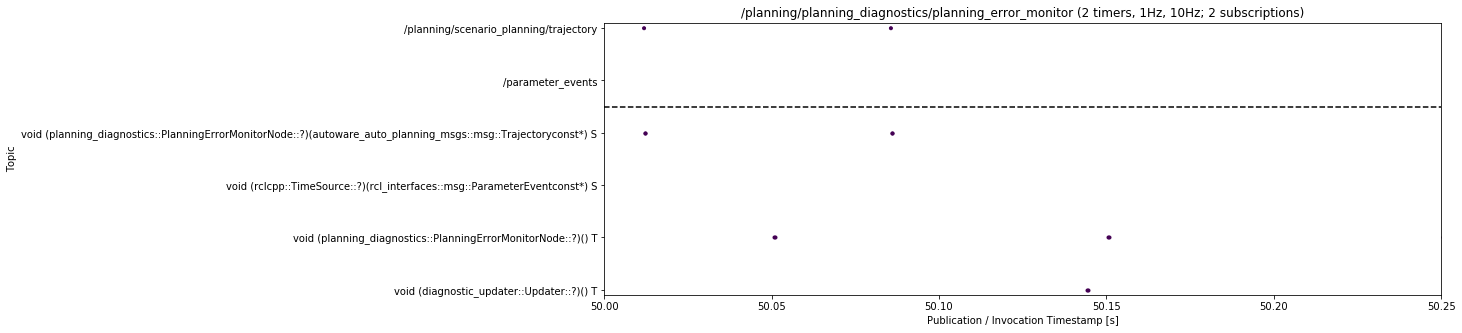

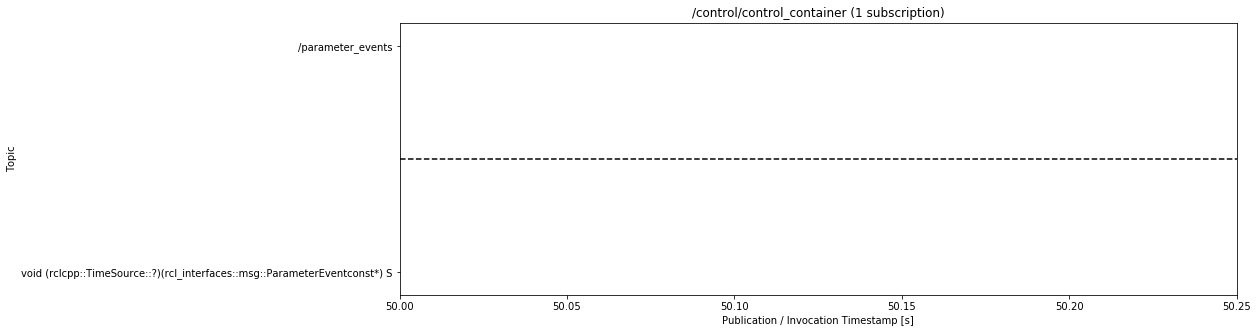

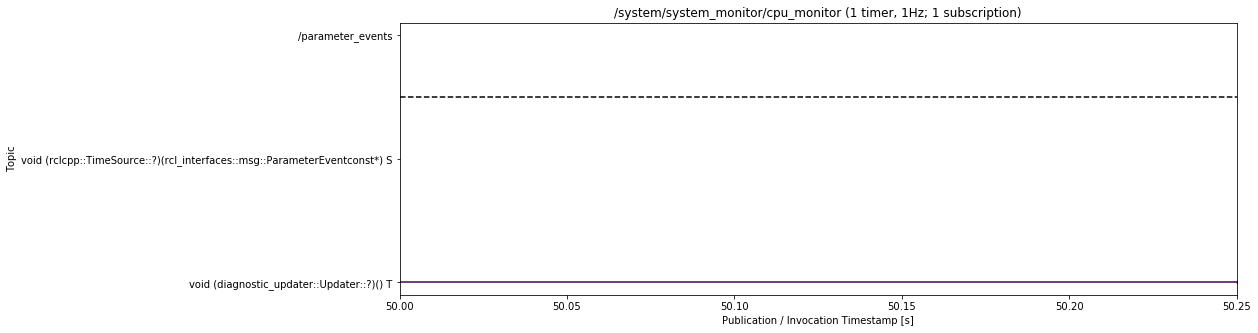

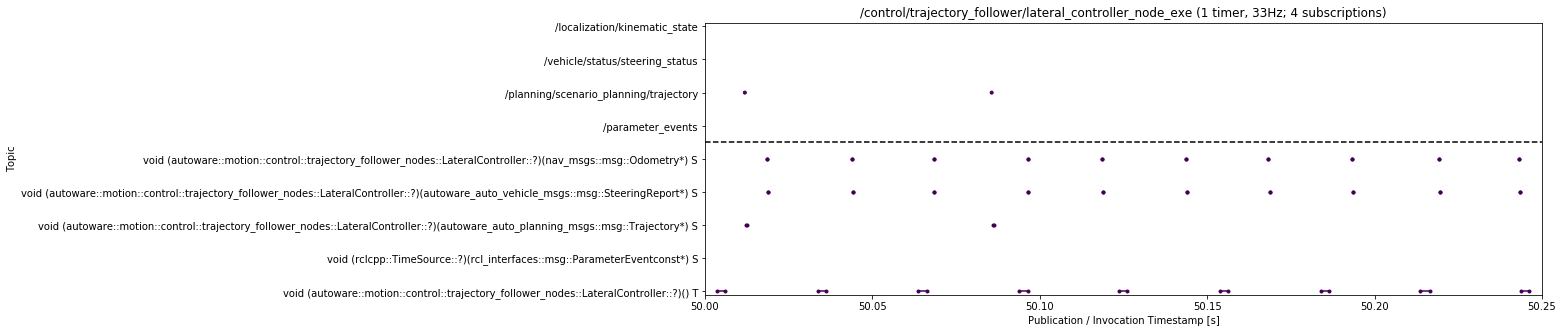

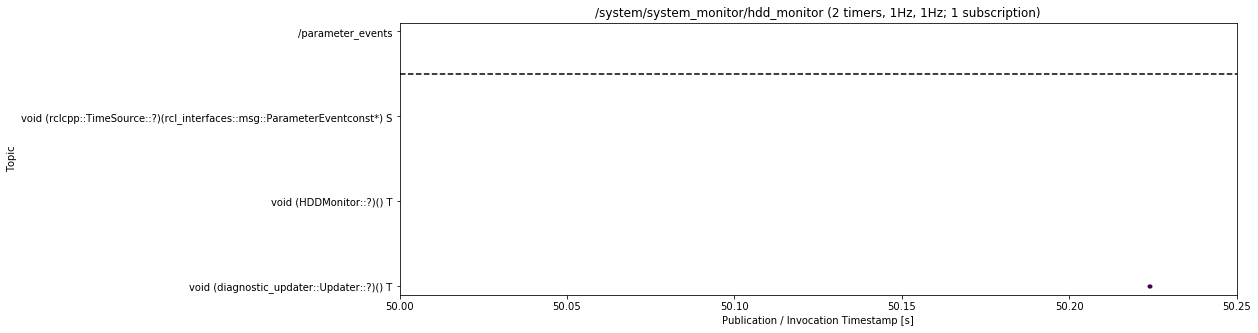

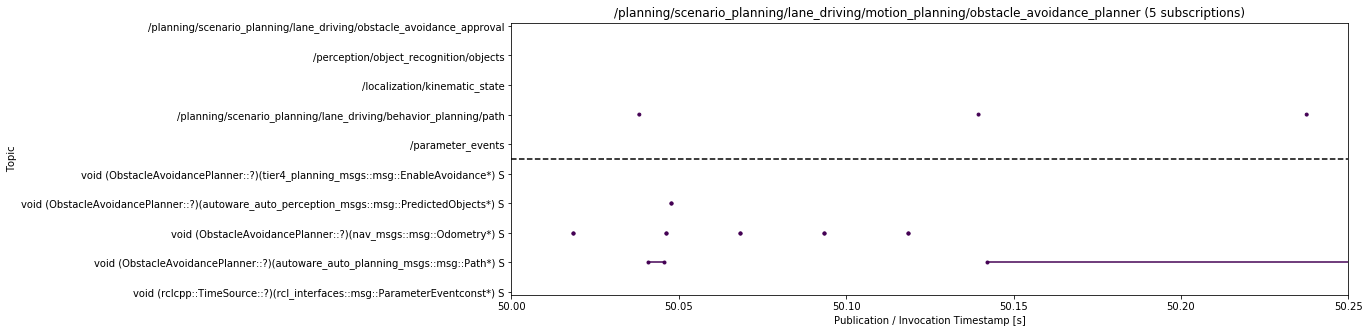

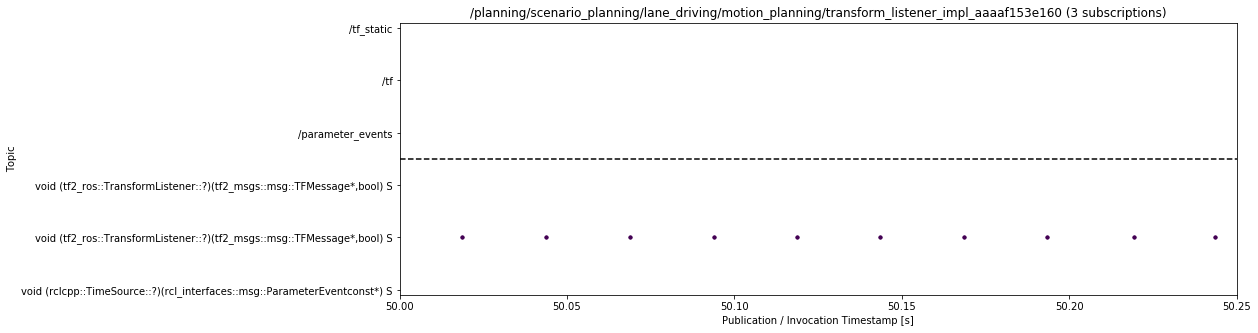

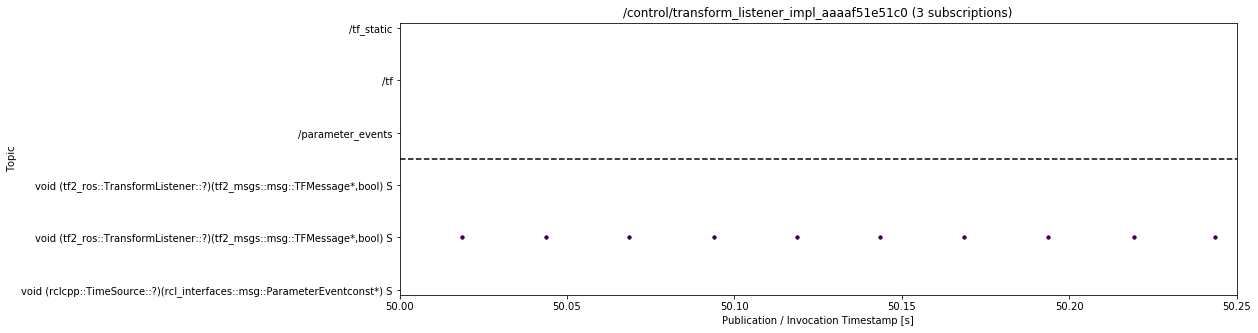

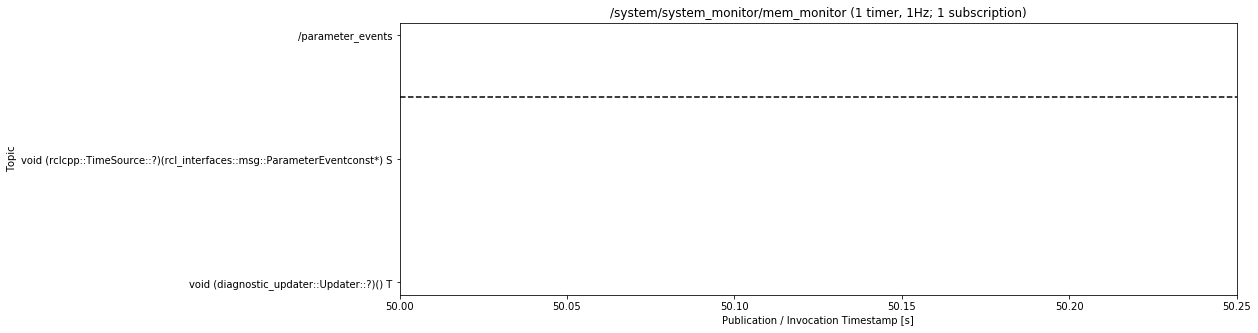

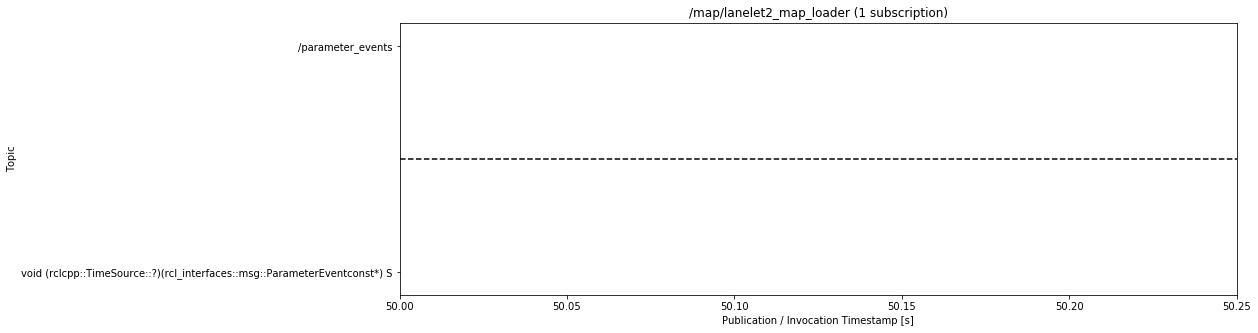

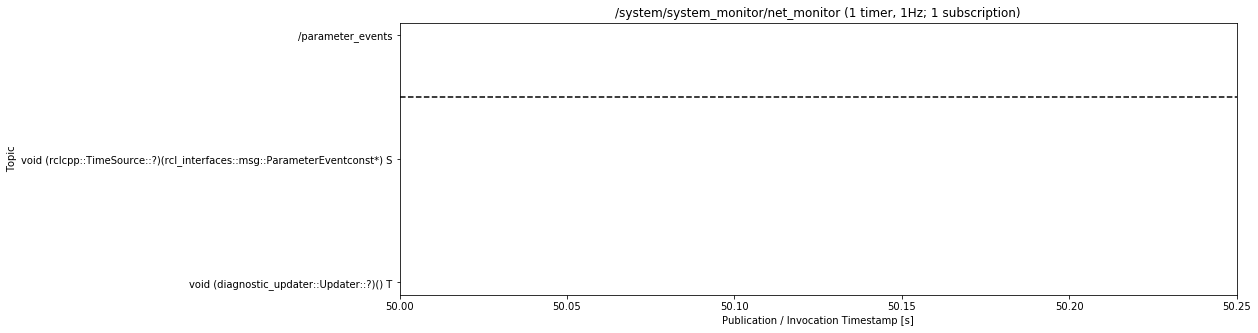

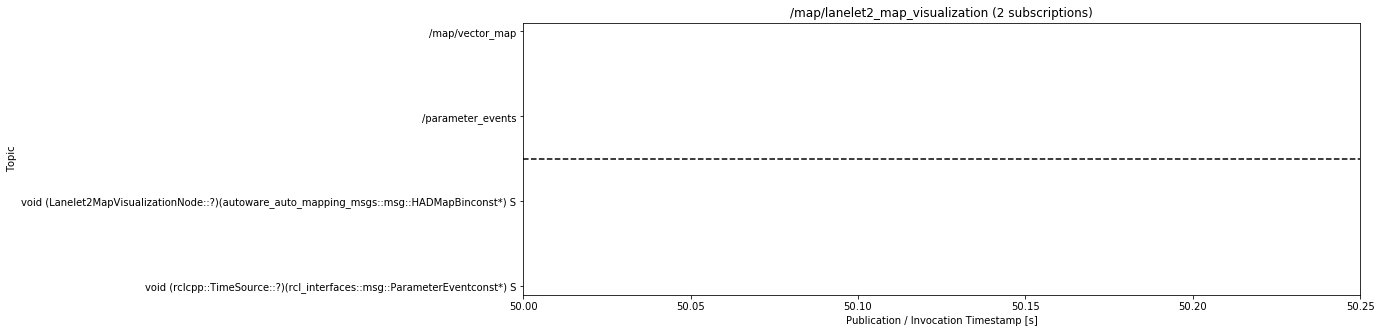

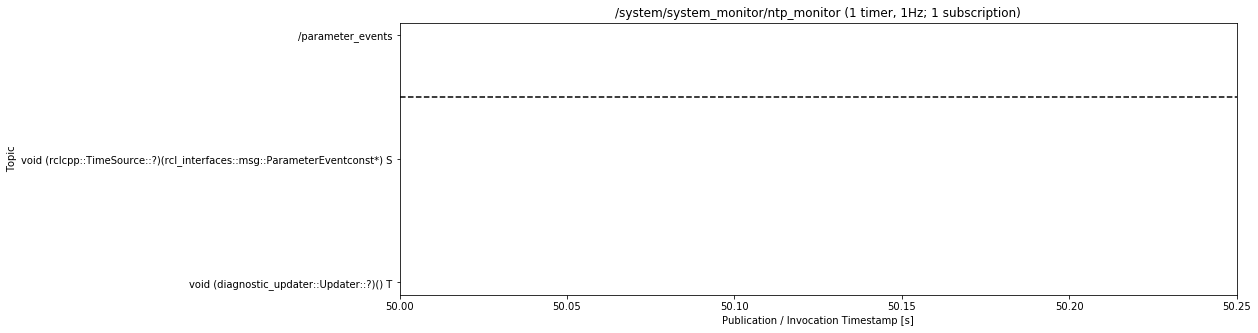

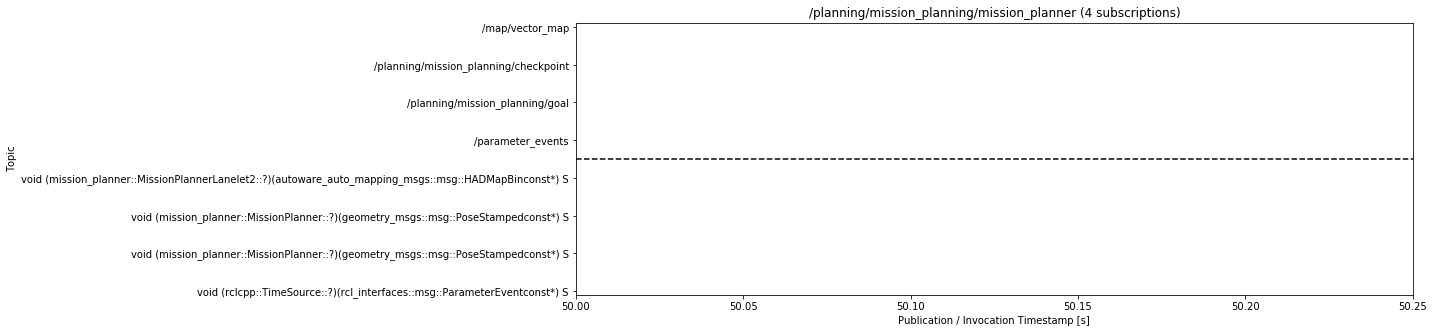

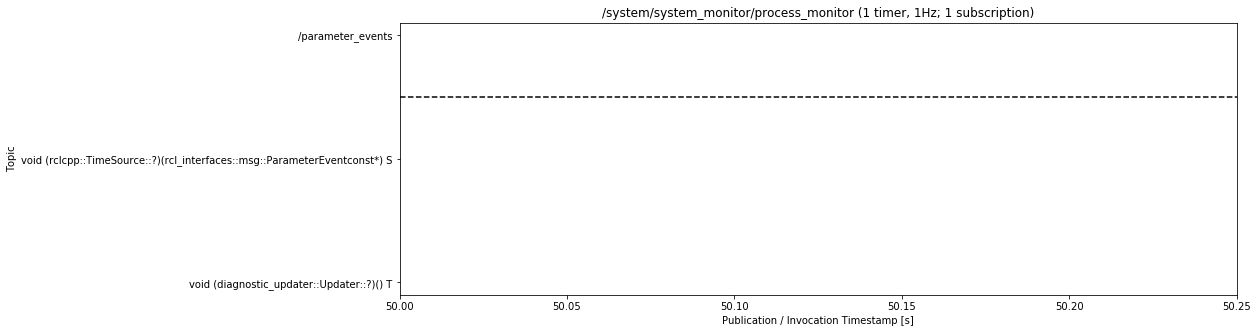

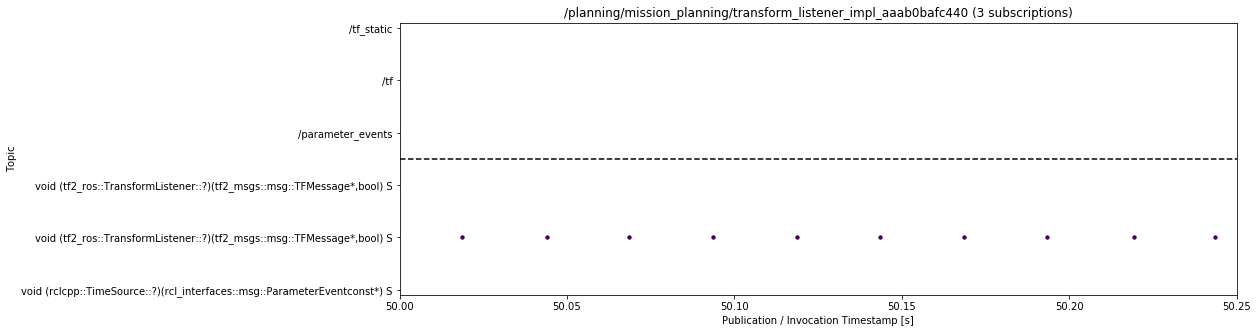

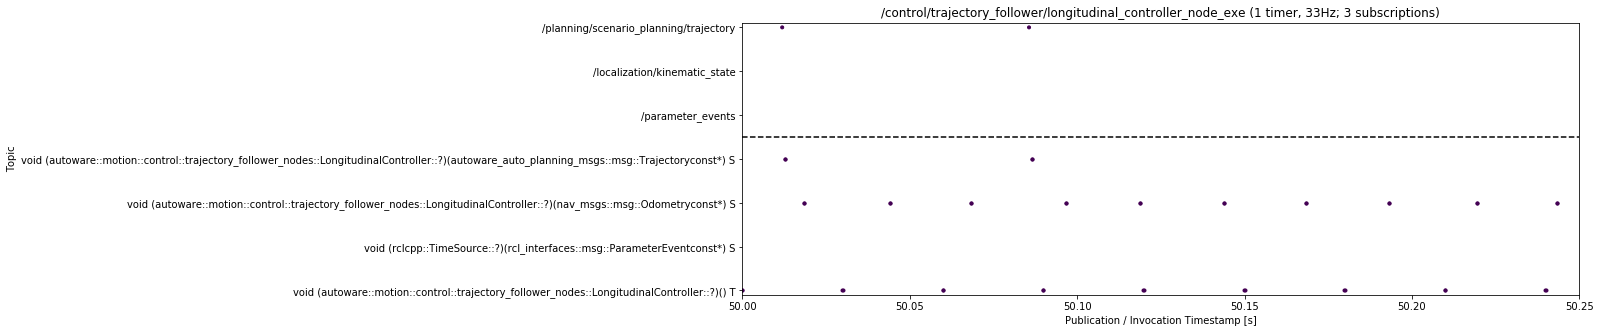

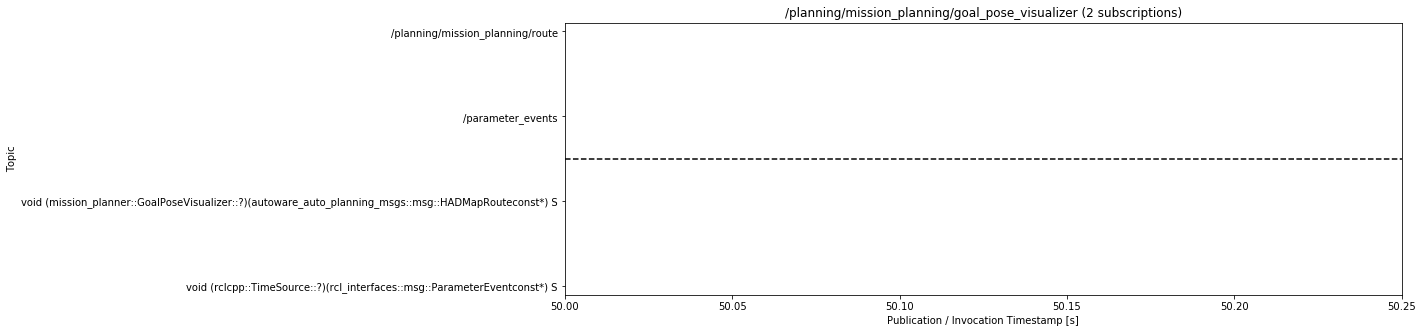

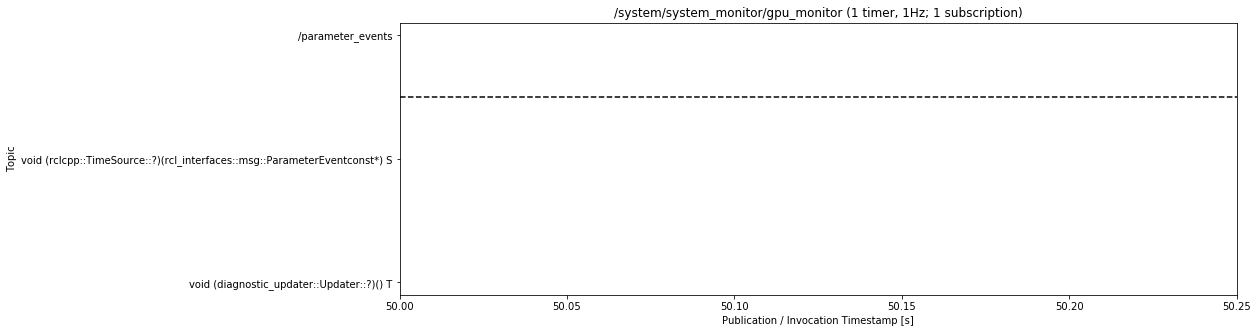

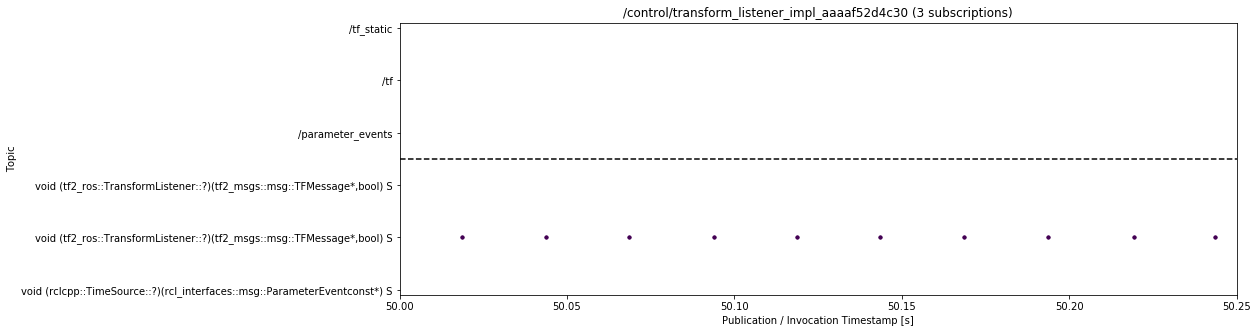

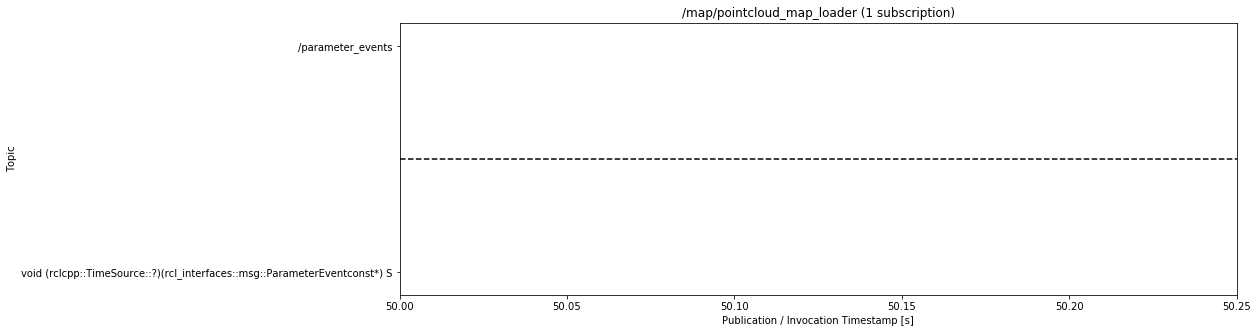

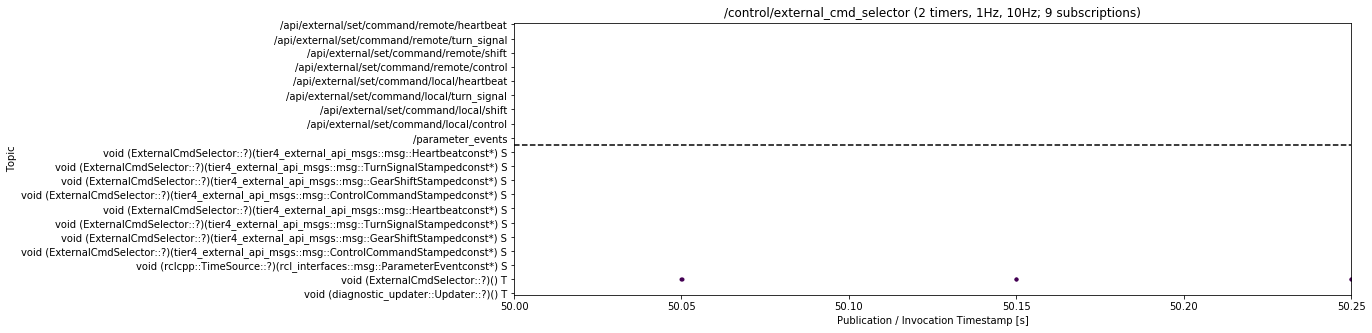

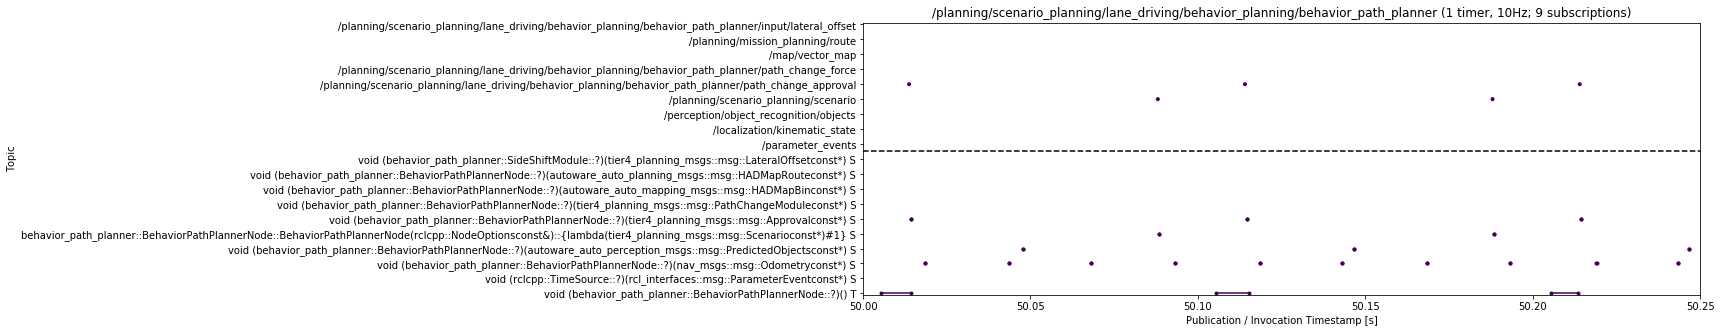

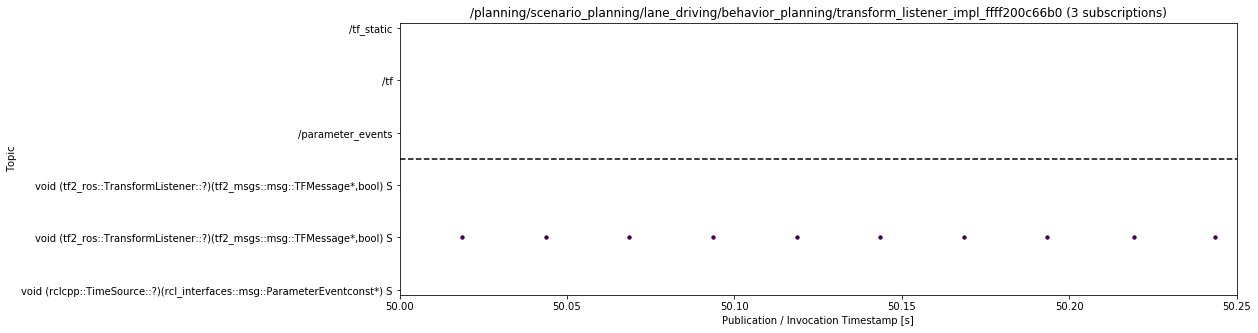

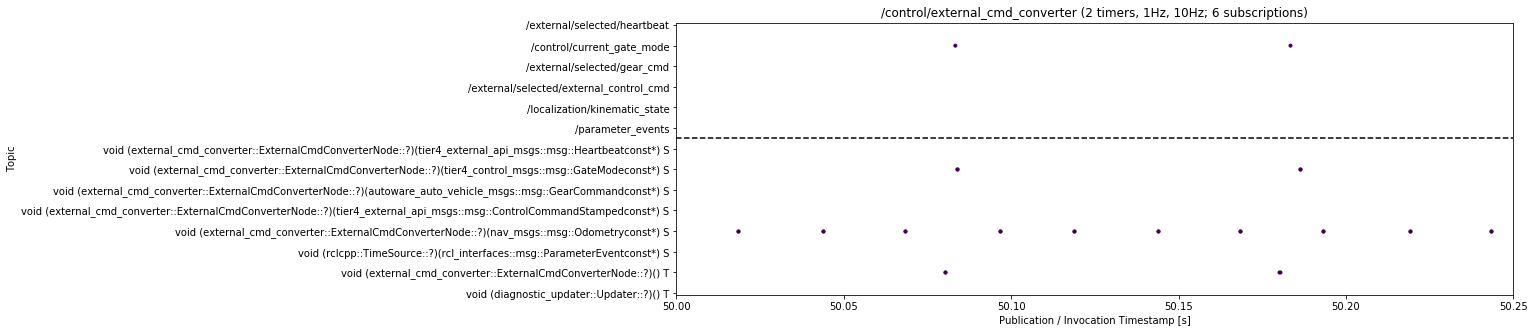

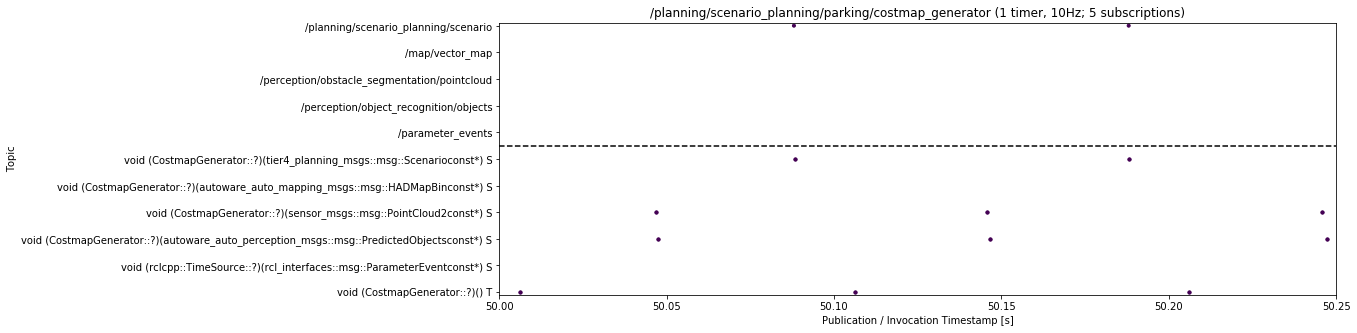

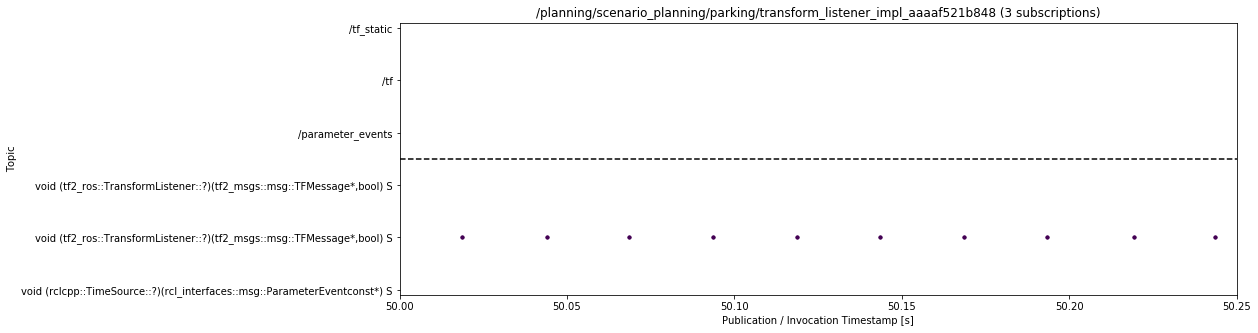

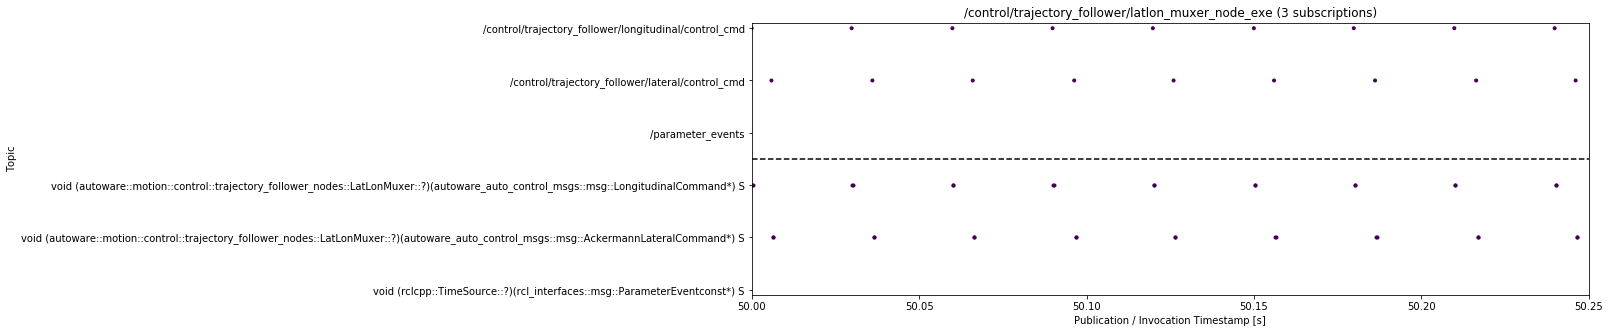

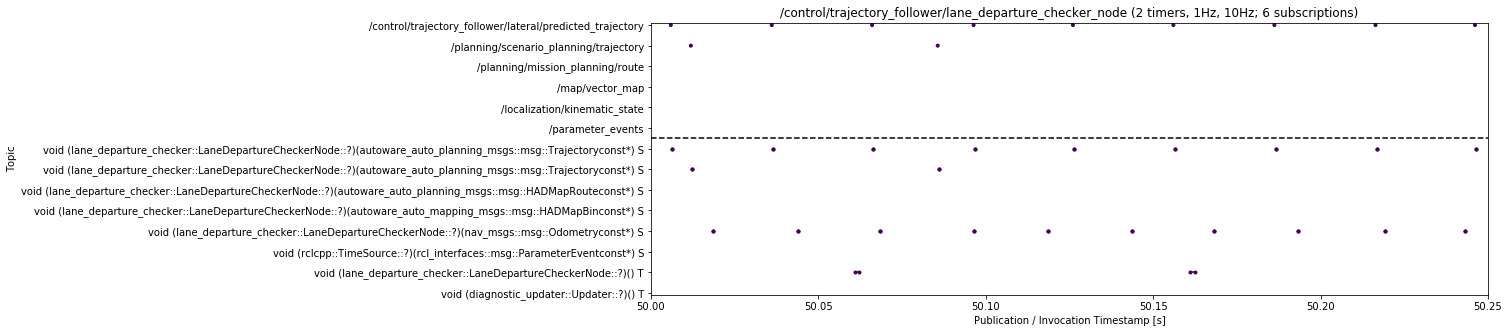

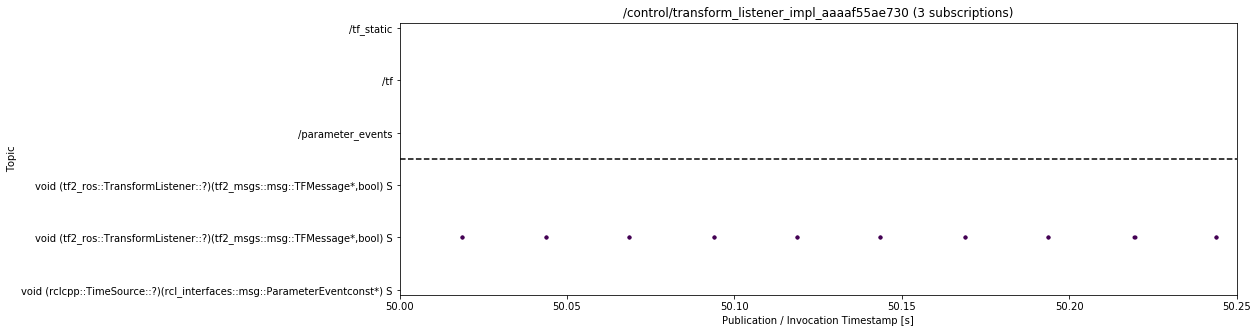

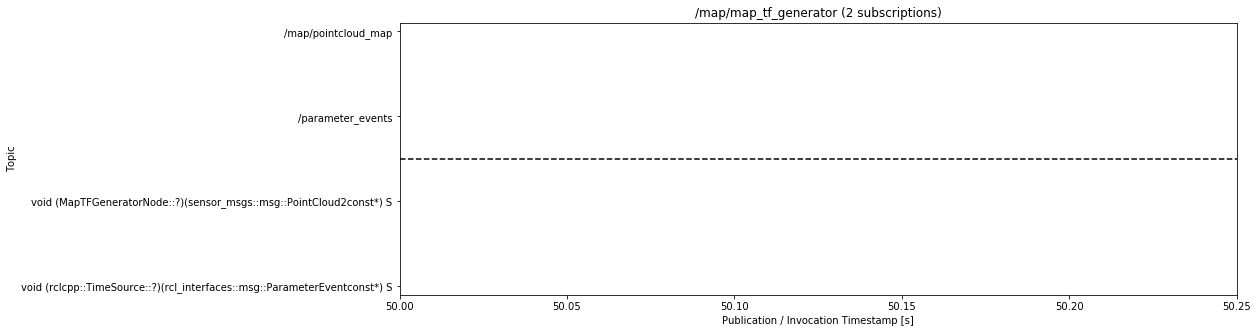

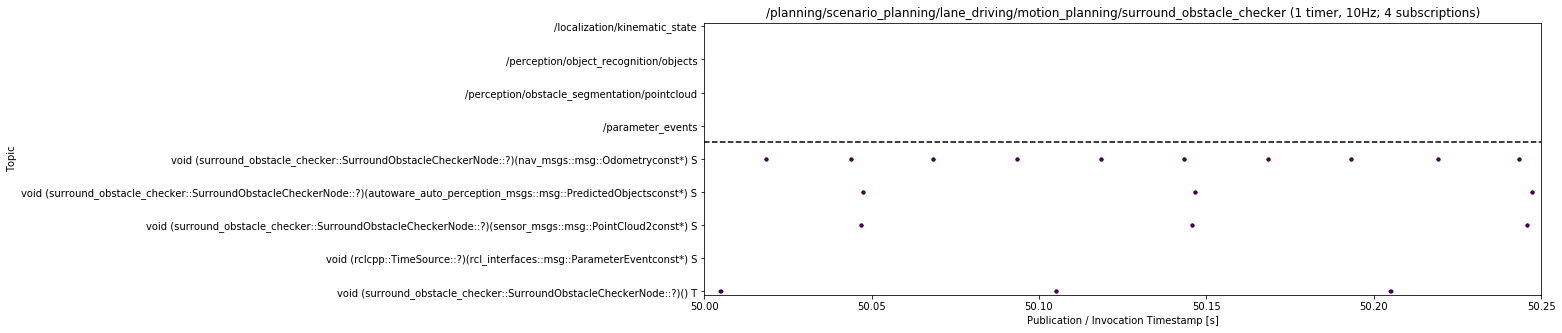

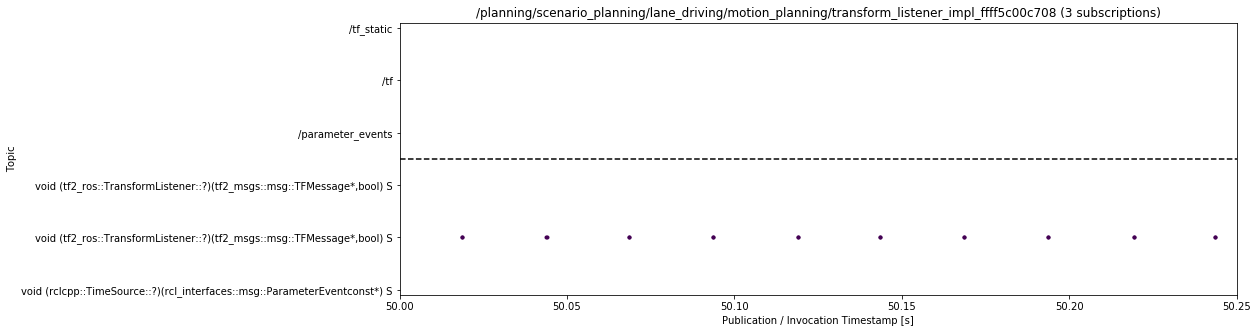

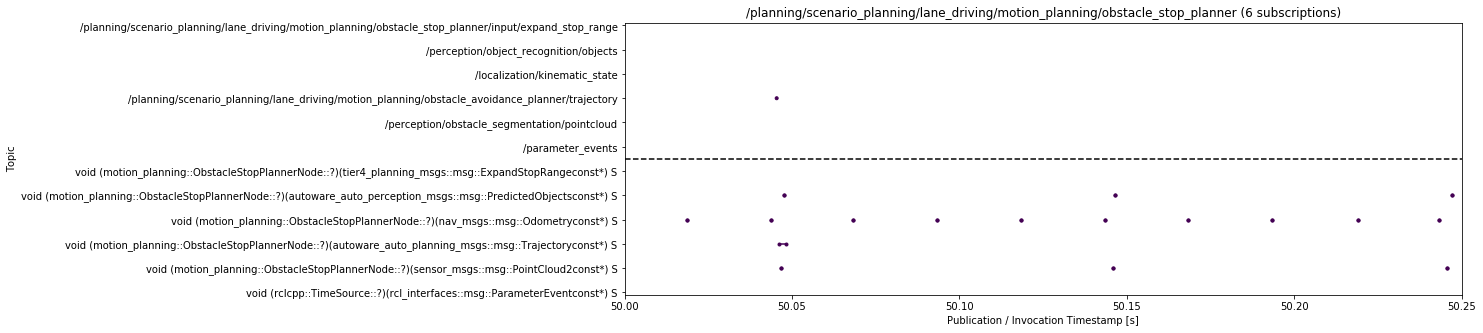

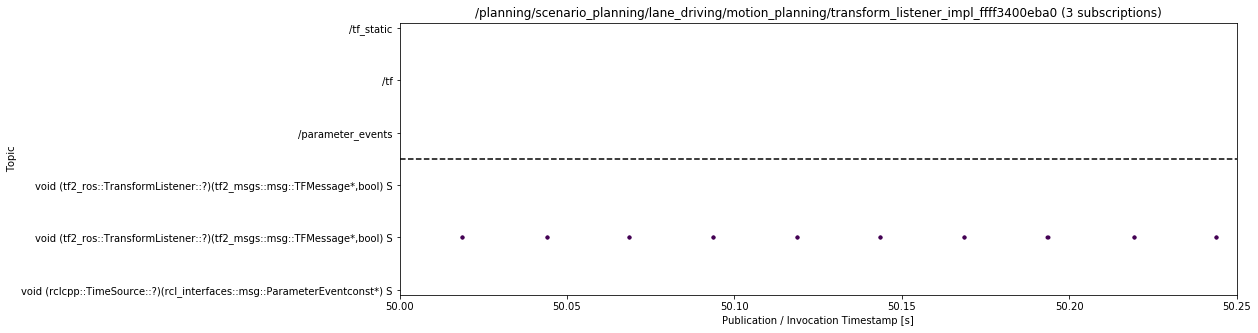

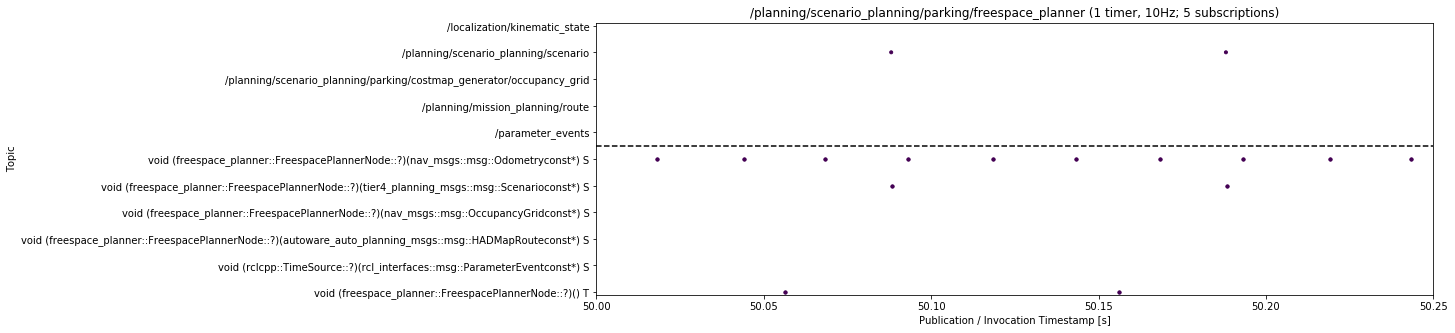

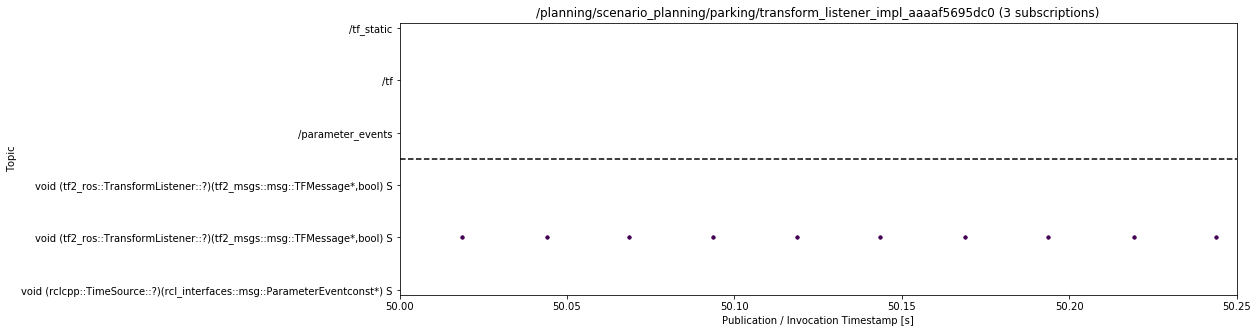

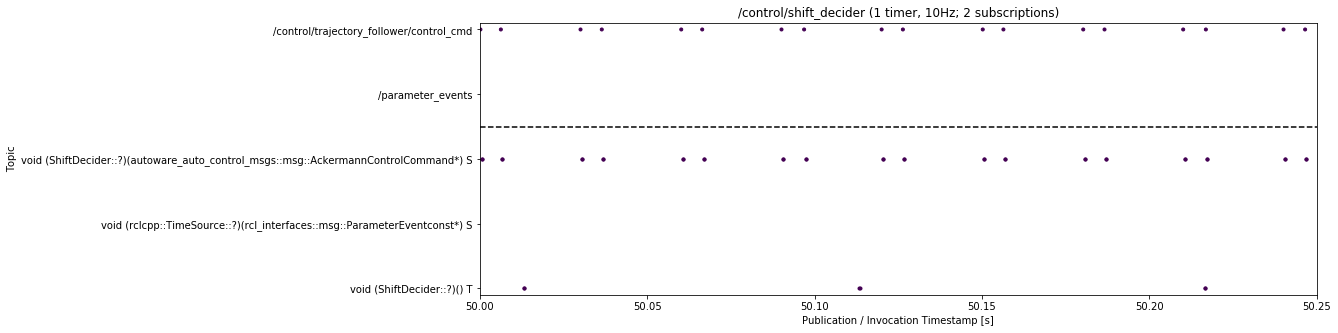

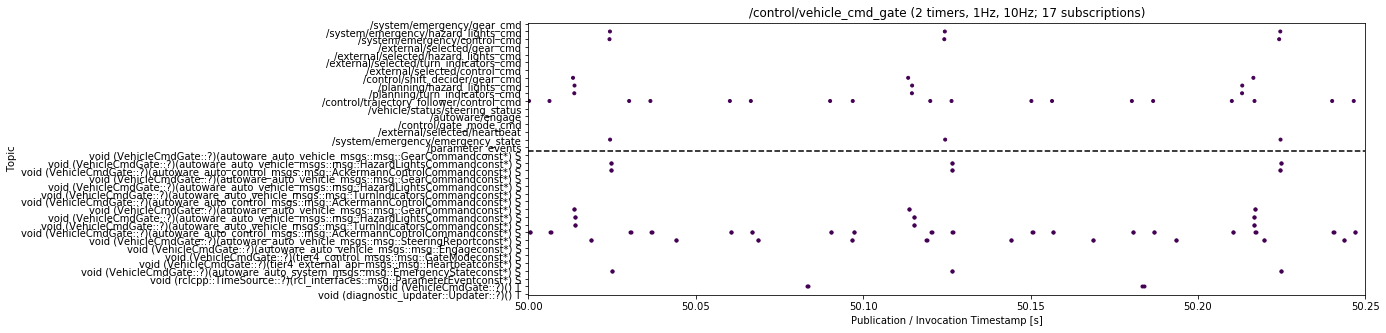

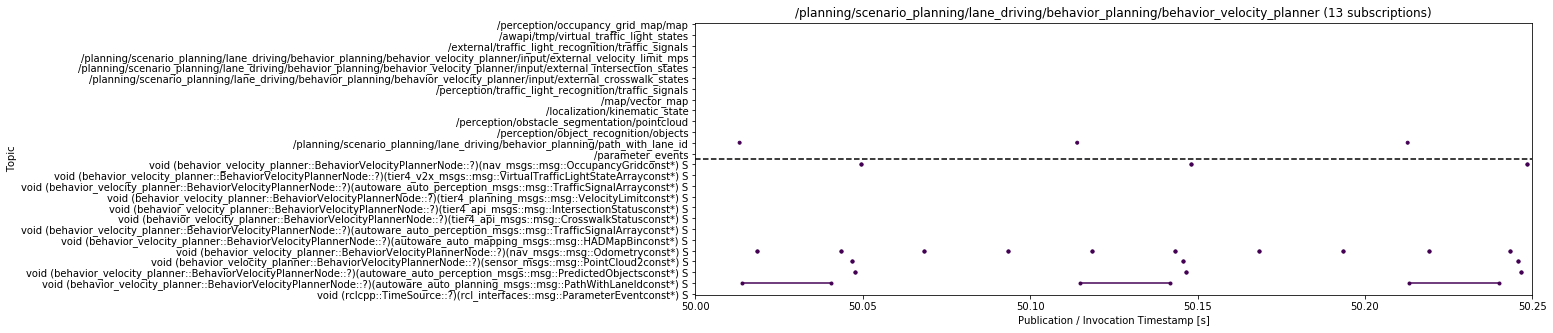

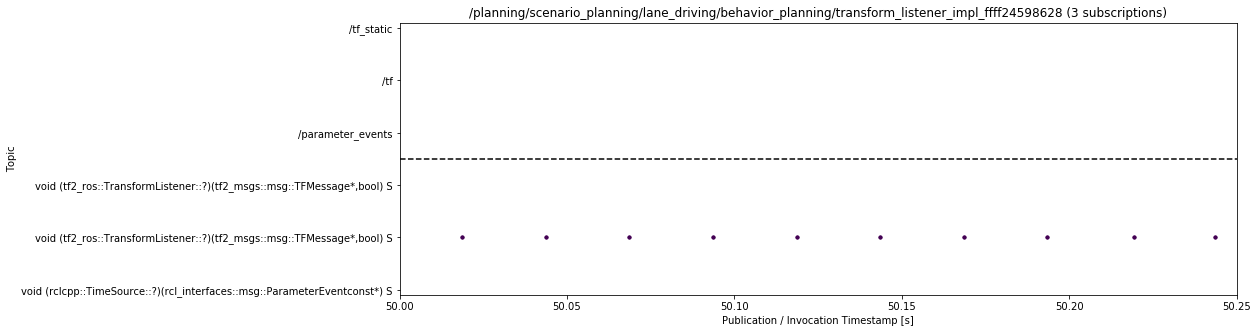

In [117]:
from matplotlib import cm

fig_dirname = "fig_pub_use"
os.makedirs(fig_dirname, exist_ok=True)
plt.close('all')

node_filters=[]#"transform_listener_impl",]

nodes_filtered = [node for node in nodes.values() if not any(f in node.path for f in node_filters)]
print(f"Ignoring {len(nodes.values()) - len(nodes_filtered)} nodes due to filters.")

common_offset = min(map(lambda cb_inst: cb_inst.timestamp.timestamp(), callback_instances))

zero_color = cm.get_cmap('viridis')(0.0)

for node_i, (node, node_path, node_pub_use_dict) in enumerate(map(lambda node: (node, node.path, pub_use_delays[node.id]), nodes_filtered)):

    if not node_pub_use_dict['invocations']:
        print(f"{node_path:95s} has no invocations, skipping.")
        continue

    if len(node_pub_use_dict['pubs']) == 0:
        print(f"Skipping {node_path}, no publications")
        continue

    fig = plt.figure(figsize=(15,5))
    ax: plt.Axes = fig.add_subplot()

    max_pubs_per_topic = max(len(pubs) for pubs in node_pub_use_dict['pubs'].values())
    topic_names, topic_pubs = (zip(*node_pub_use_dict['pubs'].items()))

    vmin = 0; vmax = max_pubs_per_topic

    y_labels = []
    current_y = 0

    for invoc_i, (cb_obj_id, cb_invocations) in enumerate(node_pub_use_dict['invocations'].items()):
        try:
            cb_obj = callback_objects[cb_obj_id]
            sym = callback_symbols[cb_obj.callback_object].symbol
            sym = util._prettify(sym)
            sym = re.sub(r"std::shared_ptr<(.*?)>", r"\1*", sym)

            cb_owner = cb_obj.owner
            if isinstance(cb_owner, Timer):
                cb_type = "T"
            elif isinstance(cb_owner, SubscriptionObject):
                cb_type = "S"
        except KeyError or AttributeError:
            sym = "UNKNOWN"
            cb_type = "U"
        
        y_labels.append(f"{sym} {cb_type}")
        n_markers = len(cb_invocations)

        points_x = []; points_y = []
        for time, dur in cb_invocations:
            time = time.timestamp() - common_offset; dur = dur.total_seconds()
            points_x += [time, time+dur, None]
            points_y += [current_y, current_y, 0.0]
        
        ax.plot(points_x,points_y, marker='.', c=zero_color)
        current_y += 1

    n_cbs = current_y

    for topic_i, (topic_name, pubs) in enumerate(zip(topic_names, topic_pubs)):
        for pub_i, (pub_name, timestamps) in enumerate(pubs.items()):
            n_markers = len(timestamps)
            ax.scatter(np.array(timestamps)*1e-9 - common_offset, (current_y,) * n_markers, marker='.', c=(pub_i,) * n_markers, vmin=vmin, vmax=vmax)
        
        y_labels.append(topic_name)
        current_y += 1
    
    trigger_strs = []
    t = node.timers
    if t:
        n_timers = len(t)
        freqs = map(lambda timer: 1 / (timer.period*1e-9), t)
        trigger_strs.append(f"{n_timers} timer{'s' if n_timers != 1 else ''}, {'Hz, '.join((f'{freq:.0f}' for freq in freqs))}Hz")
    if node.subscriptions:
        n_subs = len(node.subscriptions)
        trigger_strs.append(f"{n_subs} subscription{'s' if n_subs != 1 else ''}")

    ax.set_xlabel("Publication / Invocation Timestamp [s]")
    ax.set_ylabel("Topic")
    ax.set_yticks(range(current_y))
    ax.set_yticklabels(y_labels)
    ax.set_ylim(0 - .1, current_y - 1 + .1)
    ax.set_title(f"{node_path} ({'; '.join(trigger_strs)})")
    ax.set_xlim(50, 50.25)

    ax.hlines(n_cbs - 0.5, *ax.get_xlim(), linestyles='dashed')
    plt.savefig(os.path.join(fig_dirname, f"{node_i:06}{node_path}".replace('/','-')))